# Source of Code:
This code reproduces the results of the “Statistical supervised meta-ensemble algorithm for medical record linkage” paper. The vast majority of this code was sourced from the original paper’s GitHub repository. The original code has been slightly modified and amended.

K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.

# Sensitivity to the Amount of Training Data Ablation:
This additional ablation file assesses the neural network models’ sensitivity to the structure of hidden layers. This analysis was performed on the base learners “NN” and “NN-bag”. Since “NN-bag” is a component of the ensemble model, the effect of the hidden layer changes was also monitored for the ensemble model.Specifically, the following hidden layer structures we tried and evaluated. 
1. One hidden layer: varying the number of nodes in the hidden layer from 50, 100, 256, 300, 400, to 600
2. Two hidden layers: The first hidden layer having 256 nodes and the second hidden layer having 50, 100, 256, 300, 400, to 600 nodes.

This analysis is performed using the FEBRL dataset and the models corresponding to the FEBRL dataset as specified in Table 3 of the paper. 

# Source of Dataset:
The FEBRL datasets used in this experiment trial were the febrl3_UNSW.csv and febrl4_UNSW.csv files produced by the Preparing_FEBRL_and_ePBRN_Datasets.ipynb file. These FEBRL datasets are slightly different than the FEBRL datasets published on the author's GitHub repository https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.  This is because the FEBRL datasets are generated using the Python Record Linkage Toolkit library. As a result, the generated dataset is dependent on the version of Python Record Linkage Toolkit library at the time.  When consulting with Jitendra Jonnagaddala, one of the paper's authors, it was stated that a reasonable explanation for this observed difference between the FEBRL datasets published on the authors' GitHub and the current regeneration of the datasets using the Python Record Linkage Toolkit library was due to changes in the library. The paper was published in 2019 and the most recent change to the library was committed on April 19, 2022. https://github.com/J535D165/recordlinkage

# 1.0 Importing Libraries

In [1]:
'''
Source: 
K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
'''
import recordlinkage as rl, pandas as pd, numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from recordlinkage.preprocessing import phonetic
from numpy.random import choice
import collections, numpy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split, KFold
from math import comb
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
np.random.seed(0)

# 2.0 FEBRL Helper Functions

In [3]:
'''
Source: 
K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
'''
def generate_true_links(df): 
    # although the match_id column is included in the original df to imply the true links,
    # this function will create the true_link object identical to the true_links properties
    # of recordlinkage toolkit, in order to exploit "Compare.compute()" from that toolkit
    # in extract_function() for extracting features quicker.
    # This process should be deprecated in the future release of the UNSW toolkit.
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    processed = 0
    for match_id in df["match_id"].unique():
        if match_id != -1:    
            processed = processed + 1
            # print("In routine generate_true_links(), count =", processed)
            # clear_output(wait=True)
            linkages = df.loc[df['match_id'] == match_id]
            for j in range(len(linkages)-1):
                for k in range(j+1, len(linkages)):
                    indices_1 = indices_1 + [linkages.iloc[j]["rec_id"]]
                    indices_2 = indices_2 + [linkages.iloc[k]["rec_id"]]    
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    return links

'''
Source: 
K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
'''
def generate_false_links(df, size):
    # A counterpart of generate_true_links(), with the purpose to generate random false pairs
    # for training. The number of false pairs in specified as "size".
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    unique_match_id = df["match_id"].unique()
    for j in range(size):
            false_pair_ids = choice(unique_match_id, 2)
            candidate_1_cluster = df.loc[df['match_id'] == false_pair_ids[0]]
            candidate_1 = candidate_1_cluster.iloc[choice(range(len(candidate_1_cluster)))]
            candidate_2_cluster = df.loc[df['match_id'] == false_pair_ids[1]]
            candidate_2 = candidate_2_cluster.iloc[choice(range(len(candidate_2_cluster)))]    
            indices_1 = indices_1 + [candidate_1["rec_id"]]
            indices_2 = indices_2 + [candidate_2["rec_id"]]  
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    return links

'''
Source: 
K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
'''
def swap_fields_flag(f11, f12, f21, f22):
    return int((f11 == f22) and (f12 == f21))

'''
Source: 
K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
'''
def extract_features(df, links):
    c = rl.Compare()
    c.string('given_name', 'given_name', method='jarowinkler', label='y_name')
    c.string('given_name_soundex', 'given_name_soundex', method='jarowinkler', label='y_name_soundex')
    c.string('given_name_nysiis', 'given_name_nysiis', method='jarowinkler', label='y_name_nysiis')
    c.string('surname', 'surname', method='jarowinkler', label='y_surname')
    c.string('surname_soundex', 'surname_soundex', method='jarowinkler', label='y_surname_soundex')
    c.string('surname_nysiis', 'surname_nysiis', method='jarowinkler', label='y_surname_nysiis')
    c.exact('street_number', 'street_number', label='y_street_number')
    c.string('address_1', 'address_1', method='levenshtein', threshold=0.7, label='y_address1')
    c.string('address_2', 'address_2', method='levenshtein', threshold=0.7, label='y_address2')
    c.exact('postcode', 'postcode', label='y_postcode')
    c.exact('day', 'day', label='y_day')
    c.exact('month', 'month', label='y_month')
    c.exact('year', 'year', label='y_year')
        
    # Build features
    feature_vectors = c.compute(links, df, df)
    return feature_vectors

'''
Source: 
K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
'''
def generate_train_X_y(df):
    # This routine is to generate the feature vector X and the corresponding labels y
    # with exactly equal number of samples for both classes to train the classifier.
    pos = extract_features(df, train_true_links)
    train_false_links = generate_false_links(df, len(train_true_links))    
    neg = extract_features(df, train_false_links)
    X = pos.values.tolist() + neg.values.tolist()
    y = [1]*len(pos)+[0]*len(neg)
    X, y = shuffle(X, y, random_state=0)
    X = np.array(X)
    y = np.array(y)
    return X, y

'''
Source: 
K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.

This function was modified slightly to provide a random state and provide another parameter for the hidden layer 
structure for the NN model
'''
def train_model(modeltype, modelparam, modelparam_2, train_vectors, train_labels, modeltype_2):
    if modeltype == 'svm': # Support Vector Machine
        '''
        Original line of code provided by the paper’s authors:
        model = svm.SVC(C = modelparam, kernel = modeltype_2)
        '''
        
        model = svm.SVC(C = modelparam, kernel = modeltype_2, random_state=0)
        
        model.fit(train_vectors, train_labels) 
    elif modeltype == 'lg': # Logistic Regression
        '''
        Original line of code provided by the paper’s authors:
        model = LogisticRegression(C=modelparam, penalty = modeltype_2,class_weight=None, dual=False, fit_intercept=True, 
                                   intercept_scaling=1, max_iter=5000, multi_class='ovr', 
                                   n_jobs=1, random_state=None)
        '''
        model = LogisticRegression(C=modelparam, penalty = modeltype_2,class_weight=None, dual=False, fit_intercept=True, 
                                   intercept_scaling=1, max_iter=5000, multi_class='ovr', 
                                   n_jobs=1, random_state=0)
        
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nb': # Naive Bayes
        model = GaussianNB()
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nn': # Neural Network
        '''
        Original line of code provided by the paper’s authors
        model = MLPClassifier(solver='lbfgs', alpha=modelparam, hidden_layer_sizes=(256, ), 
                              activation = modeltype_2,random_state=None, batch_size='auto', 
                              learning_rate='constant',  learning_rate_init=0.001, 
                              power_t=0.5, max_iter=10000, shuffle=True, 
                              tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                              nesterovs_momentum=True, early_stopping=False, 
                              validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        '''
        model = MLPClassifier(solver='lbfgs', alpha=modelparam, hidden_layer_sizes=modelparam_2, 
                              activation = modeltype_2,random_state=0, batch_size='auto', 
                              learning_rate='constant',  learning_rate_init=0.001, 
                              power_t=0.5, max_iter=10000, shuffle=True, 
                              tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                              nesterovs_momentum=True, early_stopping=False, 
                              validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        
        model.fit(train_vectors, train_labels)
    return model

'''
Source: 
K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
'''
def classify(model, test_vectors):
    result = model.predict(test_vectors)
    return result

'''
Source: 
K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
'''    
def evaluation(test_labels, result):
    true_pos = np.logical_and(test_labels, result)
    count_true_pos = np.sum(true_pos)
    true_neg = np.logical_and(np.logical_not(test_labels),np.logical_not(result))
    count_true_neg = np.sum(true_neg)
    false_pos = np.logical_and(np.logical_not(test_labels), result)
    count_false_pos = np.sum(false_pos)
    false_neg = np.logical_and(test_labels,np.logical_not(result))
    count_false_neg = np.sum(false_neg)
    precision = count_true_pos/(count_true_pos+count_false_pos)
    sensitivity = count_true_pos/(count_true_pos+count_false_neg) # sensitivity = recall
    confusion_matrix = [count_true_pos, count_false_pos, count_false_neg, count_true_neg]
    no_links_found = np.count_nonzero(result)
    no_false = count_false_pos + count_false_neg
    Fscore = 2*precision*sensitivity/(precision+sensitivity)
    metrics_result = {'no_false':no_false, 'confusion_matrix':confusion_matrix ,'precision':precision,
                     'sensitivity':sensitivity ,'no_links':no_links_found, 'F-score': Fscore}
    return metrics_result

'''
Source: 
K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
'''
def blocking_performance(candidates, true_links, df):
    count = 0
    for candi in candidates:
        if df.loc[candi[0]]["match_id"]==df.loc[candi[1]]["match_id"]:
            count = count + 1
    return count

# 3.0 FEBRL Running the Experiment with Varying Amounts of Training Data

In [4]:
'''
Source: 
K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
'''
trainset = 'febrl3_UNSW'
testset = 'febrl4_UNSW'

In [5]:
hidden_layer_depth_1_FEBRL_surname_nc = []
hidden_layer_depth_1_FEBRL_surname_pc = []
hidden_layer_depth_1_FEBRL_surname_rr = []
hidden_layer_depth_1_FEBRL_given_name_nc = []
hidden_layer_depth_1_FEBRL_given_name_pc = []
hidden_layer_depth_1_FEBRL_given_name_rr = []
hidden_layer_depth_1_FEBRL_postcode_nc = []
hidden_layer_depth_1_FEBRL_postcode_pc = []
hidden_layer_depth_1_FEBRL_postcode_rr = []
hidden_layer_depth_1_FEBRL_all_nc = []
hidden_layer_depth_1_FEBRL_all_pc = []
hidden_layer_depth_1_FEBRL_all_rr = []

In [6]:
hidden_layer_depth_1_FEBRL_svm_pr = []
hidden_layer_depth_1_FEBRL_svm_re = []
hidden_layer_depth_1_FEBRL_svm_fs = []
hidden_layer_depth_1_FEBRL_svm_fc = []
hidden_layer_depth_1_FEBRL_svm_bag_pr = []
hidden_layer_depth_1_FEBRL_svm_bag_re = []
hidden_layer_depth_1_FEBRL_svm_bag_fs = []
hidden_layer_depth_1_FEBRL_svm_bag_fc = []
hidden_layer_depth_1_FEBRL_nn_pr = []
hidden_layer_depth_1_FEBRL_nn_re = []
hidden_layer_depth_1_FEBRL_nn_fs = []
hidden_layer_depth_1_FEBRL_nn_fc = []
hidden_layer_depth_1_FEBRL_nn_bag_pr = []
hidden_layer_depth_1_FEBRL_nn_bag_re = []
hidden_layer_depth_1_FEBRL_nn_bag_fs = []
hidden_layer_depth_1_FEBRL_nn_bag_fc = []
hidden_layer_depth_1_FEBRL_lr_pr = []
hidden_layer_depth_1_FEBRL_lr_re = []
hidden_layer_depth_1_FEBRL_lr_fs = []
hidden_layer_depth_1_FEBRL_lr_fc = []
hidden_layer_depth_1_FEBRL_lr_bag_pr = []
hidden_layer_depth_1_FEBRL_lr_bag_re = []
hidden_layer_depth_1_FEBRL_lr_bag_fs = []
hidden_layer_depth_1_FEBRL_lr_bag_fc = []
hidden_layer_depth_1_FEBRL_ensemble_pr = []
hidden_layer_depth_1_FEBRL_ensemble_re = []
hidden_layer_depth_1_FEBRL_ensemble_fs = []
hidden_layer_depth_1_FEBRL_ensemble_fc = []

In [7]:
one_layer_hidden_size = [(50,), (100,), (256,), (300,), (400,), (600,)]
two_layer_hidden_size = [(256,50), (256,100), (256,256), (256,300), (256,400), (256,600)]

In [8]:
counter = 0
for hidden_layer_size in one_layer_hidden_size:
    print("")
    print("ITERATION: ", counter, "hidden_layer_size: ", hidden_layer_size)
    print("")
    
    '''
    Source: 
    K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
    Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
    
    Code has been modified to change in dataset size according to the specified factor
    '''
    
    trainset = 'febrl3_UNSW'
    testset = 'febrl4_UNSW'
    
    print("Import train set...")
    df_train = pd.read_csv(trainset+".csv", index_col = "rec_id")
    train_true_links = generate_true_links(df_train)

    # Preprocess train set
    df_train['postcode'] = df_train['postcode'].astype(str)
    df_train['given_name_soundex'] = phonetic(df_train['given_name'], method='soundex')
    df_train['given_name_nysiis'] = phonetic(df_train['given_name'], method='nysiis')
    df_train['surname_soundex'] = phonetic(df_train['surname'], method='soundex')
    df_train['surname_nysiis'] = phonetic(df_train['surname'], method='nysiis')

    # Final train feature vectors and labels
    X_train, y_train = generate_train_X_y(df_train)
    print("Finished building X_train, y_train")
    
    # 2. FEBRL Blocking Results ######################################################################################
    print("FEBRL Blocking Results")
    '''
    Source: 
    K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
    Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.

    Code has been modified to reproduce and print Table 4 of the paper.
    '''
    # Blocking Criteria: declare non-match of all of the below fields disagree
    # Import
    print("Import test set...")
    FEBRL_blocking_results = []
    df_test = pd.read_csv(testset+".csv", index_col = "rec_id")
    test_true_links = generate_true_links(df_test)
    leng_test_true_links = len(test_true_links)
    print("Test set size:", len(df_test), ", number of matched pairs: ", str(leng_test_true_links))

    total_possible_pairs = comb(len(df_test),2)
    match_pairs = leng_test_true_links

    blocking_fields = ["given_name", "surname", "postcode"]
    all_candidate_pairs = []
    for field in blocking_fields:
        block_indexer = rl.BlockIndex(on=field)
        candidates = block_indexer.index(df_test)
        detects = blocking_performance(candidates, test_true_links, df_test)
        all_candidate_pairs = candidates.union(all_candidate_pairs)
        
        # recording results for iteration
        if field == 'given_name':
            hidden_layer_depth_1_FEBRL_given_name_nc.append(len(candidates))
            hidden_layer_depth_1_FEBRL_given_name_pc.append(detects/match_pairs*100.0)
            hidden_layer_depth_1_FEBRL_given_name_rr.append((1-(len(candidates)/1.0/total_possible_pairs))*100)
        if field == 'surname':
            hidden_layer_depth_1_FEBRL_surname_nc.append(len(candidates))
            hidden_layer_depth_1_FEBRL_surname_pc.append(detects/match_pairs*100.0)
            hidden_layer_depth_1_FEBRL_surname_rr.append((1-(len(candidates)/1.0/total_possible_pairs))*100)
        if field == 'postcode':
            hidden_layer_depth_1_FEBRL_postcode_nc.append(len(candidates))
            hidden_layer_depth_1_FEBRL_postcode_pc.append(detects/match_pairs*100.0)
            hidden_layer_depth_1_FEBRL_postcode_rr.append((1-(len(candidates)/1.0/total_possible_pairs))*100)  

    detects = blocking_performance(all_candidate_pairs, test_true_links, df_test)
    
    # recording results for iteration
    hidden_layer_depth_1_FEBRL_all_nc.append(len(all_candidate_pairs))
    hidden_layer_depth_1_FEBRL_all_pc.append(detects/match_pairs*100.0)
    hidden_layer_depth_1_FEBRL_all_rr.append((1-(len(candidates)/1.0/total_possible_pairs))*100)
    
    # 3. FEBRL Classification Performance Results ####################################################################
    print("FEBRL Classification Performance Results")
    '''
    Source: 
    K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
    Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
    '''
    ## TEST SET CONSTRUCTION
    # Preprocess test set
    print("Processing test set...")
    print("Preprocess...")
    df_test['postcode'] = df_test['postcode'].astype(str)
    df_test['given_name_soundex'] = phonetic(df_test['given_name'], method='soundex')
    df_test['given_name_nysiis'] = phonetic(df_test['given_name'], method='nysiis')
    df_test['surname_soundex'] = phonetic(df_test['surname'], method='soundex')
    df_test['surname_nysiis'] = phonetic(df_test['surname'], method='nysiis')

    # Test feature vectors and labels construction
    print("Extract feature vectors...")
    df_X_test = extract_features(df_test, all_candidate_pairs)
    vectors = df_X_test.values.tolist()
    labels = [0]*len(vectors)
    feature_index = df_X_test.index
    for i in range(0, len(feature_index)):
        if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
            labels[i] = 1
    X_test, y_test = shuffle(vectors, labels, random_state=0)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    print("Count labels of y_test:",collections.Counter(y_test))
    print("Finished building X_test, y_test")

    '''
    Modifying the code provided by the authors to produce the results in Table 6 of the paper. 
    Used the hyperparameters as specified by Table 5 of the paper to build the models.

    Source: 
    K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
    Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
    '''
    # 3.1 SVM BASE LEARNERS CLASSIFICATION AND EVALUATION ############################################################
    '''
    Table 5 Hyperparameters for SVM on the FEBRL dataset
    1. Linear kernel
    2. C = 0.005
    '''
    modeltype = 'svm' # choose between 'svm', 'lg', 'nn'
    modeltype_2 = 'linear'  # 'linear' or 'rbf' for svm, 'l1' or 'l2' for lg, 'relu' or 'logistic' for nn
    modelparam = 0.005
    modelparam_2 = None

    md = train_model(modeltype, modelparam, modelparam_2, X_train, y_train, modeltype_2)
    final_result = classify(md, X_test)
    final_eval = evaluation(y_test, final_result)
    precision = final_eval['precision']
    sensitivity = final_eval['sensitivity']
    Fscore = final_eval['F-score']
    nb_false  = final_eval['no_false']
    
    hidden_layer_depth_1_FEBRL_svm_pr.append(precision)
    hidden_layer_depth_1_FEBRL_svm_re.append(sensitivity)
    hidden_layer_depth_1_FEBRL_svm_fs.append(Fscore)
    hidden_layer_depth_1_FEBRL_svm_fc.append(nb_false)

    # 3.2 NN BASE LEARNERS CLASSIFICATION AND EVALUATION #############################################################
    '''
    Table 5 Hyperparameters for NN on the FEBRL dataset
    1. ReLu activation with a = 100
    '''
    modeltype = 'nn' # choose between 'svm', 'lg', 'nn'
    modeltype_2 = 'relu'  # 'linear' or 'rbf' for svm, 'l1' or 'l2' for lg, 'relu' or 'logistic' for nn
    modelparam = 100
    modelparam_2 = hidden_layer_size

    md = train_model(modeltype, modelparam, modelparam_2, X_train, y_train, modeltype_2)
    final_result = classify(md, X_test)
    final_eval = evaluation(y_test, final_result)
    precision = final_eval['precision']
    sensitivity = final_eval['sensitivity']
    Fscore = final_eval['F-score']
    nb_false = final_eval['no_false']
    
    
    #print threes out to compare
    hidden_layer_depth_1_FEBRL_nn_pr.append(precision)
    hidden_layer_depth_1_FEBRL_nn_re.append(sensitivity)
    hidden_layer_depth_1_FEBRL_nn_fs.append(Fscore)
    hidden_layer_depth_1_FEBRL_nn_fc.append(nb_false)

    # 3.3 LR BASE LEARNERS CLASSIFICATION AND EVALUATION #############################################################
    '''
    Table 5 Hyperparameters for NN on the FEBRL dataset
    1. Regularization I2
    2. C = 0.2
    '''
    modeltype = 'lg' # choose between 'svm', 'lg', 'nn'
    modeltype_2 = 'l2'  # 'linear' or 'rbf' for svm, 'l1' or 'l2' for lg, 'relu' or 'logistic' for nn
    modelparam = 0.2
    modelparam_2 = None

    md = train_model(modeltype, modelparam, modelparam_2, X_train, y_train, modeltype_2)
    final_result = classify(md, X_test)
    final_eval = evaluation(y_test, final_result)
    precision = final_eval['precision']
    sensitivity = final_eval['sensitivity']
    Fscore = final_eval['F-score']
    nb_false = final_eval['no_false']
    
    hidden_layer_depth_1_FEBRL_lr_pr.append(precision)
    hidden_layer_depth_1_FEBRL_lr_re.append(sensitivity)
    hidden_layer_depth_1_FEBRL_lr_fs.append(Fscore)
    hidden_layer_depth_1_FEBRL_lr_fc.append(nb_false)
    
    # 3.4 BAGGING BASE LEARNERS CLASSIFICATION AND EVALUATION ########################################################
    modeltypes = ['svm', 'nn', 'lg'] 
    modeltypes_2 = ['linear', 'relu', 'l2']
    modelparams = [0.005, 100, 0.2]
    modelparams_2 = [None, hidden_layer_size, None]
    nFold = 10
    kf = KFold(n_splits=nFold)
    model_raw_score = [0]*3
    model_binary_score = [0]*3
    model_i = 0
    for model_i in range(3):
        modeltype = modeltypes[model_i]
        modeltype_2 = modeltypes_2[model_i]
        modelparam = modelparams[model_i]
        modelparam_2 = modelparams_2[model_i]
        # print(modeltype, "per fold:")
        iFold = 0
        result_fold = [0]*nFold
        final_eval_fold = [0]*nFold
        for train_index, valid_index in kf.split(X_train):
            X_train_fold = X_train[train_index]
            y_train_fold = y_train[train_index]
            md =  train_model(modeltype, modelparam, modelparam_2, X_train_fold, y_train_fold, modeltype_2)
            result_fold[iFold] = classify(md, X_test)
            final_eval_fold[iFold] = evaluation(y_test, result_fold[iFold])
            # print("Fold", str(iFold), final_eval_fold[iFold])
            iFold = iFold + 1
        bagging_raw_score = np.average(result_fold, axis=0)
        bagging_binary_score  = np.copy(bagging_raw_score)
        bagging_binary_score[bagging_binary_score > 0.5] = 1
        bagging_binary_score[bagging_binary_score <= 0.5] = 0
        bagging_eval = evaluation(y_test, bagging_binary_score)
        # print(modeltype, "bagging:", bagging_eval)
        # print('')

        if modeltype == 'svm':
            hidden_layer_depth_1_FEBRL_svm_bag_pr.append(bagging_eval['precision'])
            hidden_layer_depth_1_FEBRL_svm_bag_re.append(bagging_eval['sensitivity'])
            hidden_layer_depth_1_FEBRL_svm_bag_fs.append(bagging_eval['F-score'])
            hidden_layer_depth_1_FEBRL_svm_bag_fc.append(bagging_eval['no_false'])
        elif modeltype == 'nn':
            hidden_layer_depth_1_FEBRL_nn_bag_pr.append(bagging_eval['precision'])
            hidden_layer_depth_1_FEBRL_nn_bag_re.append(bagging_eval['sensitivity'])
            hidden_layer_depth_1_FEBRL_nn_bag_fs.append(bagging_eval['F-score'])
            hidden_layer_depth_1_FEBRL_nn_bag_fc.append(bagging_eval['no_false'])   
        elif modeltype == 'lg':
            hidden_layer_depth_1_FEBRL_lr_bag_pr.append(bagging_eval['precision'])
            hidden_layer_depth_1_FEBRL_lr_bag_re.append(bagging_eval['sensitivity'])
            hidden_layer_depth_1_FEBRL_lr_bag_fs.append(bagging_eval['F-score'])
            hidden_layer_depth_1_FEBRL_lr_bag_fc.append(bagging_eval['no_false'])

        model_raw_score[model_i] = bagging_raw_score
        model_binary_score[model_i] = bagging_binary_score
        
    # 4 Ensemble Model Performance ###################################################################################
    '''
    Source: 
    K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
    Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
    '''
    thres = .99

    stack_raw_score = np.average(model_raw_score, axis=0)
    stack_binary_score = np.copy(stack_raw_score)
    stack_binary_score[stack_binary_score > thres] = 1
    stack_binary_score[stack_binary_score <= thres] = 0
    stacking_eval = evaluation(y_test, stack_binary_score)
    
    hidden_layer_depth_1_FEBRL_ensemble_pr.append(stacking_eval['precision'])
    hidden_layer_depth_1_FEBRL_ensemble_re.append(stacking_eval['sensitivity'])
    hidden_layer_depth_1_FEBRL_ensemble_fs.append(stacking_eval['F-score'])
    hidden_layer_depth_1_FEBRL_ensemble_fc.append(stacking_eval['no_false'])
          
    print("ensemble pr: ", stacking_eval['precision'])
    print("ensemble re: ", stacking_eval['sensitivity'])
    print("ensemble fs: ", stacking_eval['F-score'])
    print("ensemble fc: ", stacking_eval['no_false'])
    counter += 1


ITERATION:  0 hidden_layer_size:  (50,)

Import train set...
Finished building X_train, y_train
FEBRL Blocking Results
Import test set...
Test set size: 10000 , number of matched pairs:  5000
FEBRL Classification Performance Results
Processing test set...
Preprocess...
Extract feature vectors...
Count labels of y_test: Counter({0: 367179, 1: 4894})
Finished building X_test, y_test
ensemble pr:  0.9816717019133937
ensemble re:  0.9959133633020024
ensemble fs:  0.9887412516482401
ensemble fc:  111

ITERATION:  1 hidden_layer_size:  (100,)

Import train set...
Finished building X_train, y_train
FEBRL Blocking Results
Import test set...
Test set size: 10000 , number of matched pairs:  5000
FEBRL Classification Performance Results
Processing test set...
Preprocess...
Extract feature vectors...
Count labels of y_test: Counter({0: 367179, 1: 4894})
Finished building X_test, y_test
ensemble pr:  0.9846464646464647
ensemble re:  0.9959133633020024
ensemble fs:  0.9902478667208451
ensemble fc: 

In [9]:
hidden_layer_depth_2_FEBRL_surname_nc = []
hidden_layer_depth_2_FEBRL_surname_pc = []
hidden_layer_depth_2_FEBRL_surname_rr = []
hidden_layer_depth_2_FEBRL_given_name_nc = []
hidden_layer_depth_2_FEBRL_given_name_pc = []
hidden_layer_depth_2_FEBRL_given_name_rr = []
hidden_layer_depth_2_FEBRL_postcode_nc = []
hidden_layer_depth_2_FEBRL_postcode_pc = []
hidden_layer_depth_2_FEBRL_postcode_rr = []
hidden_layer_depth_2_FEBRL_all_nc = []
hidden_layer_depth_2_FEBRL_all_pc = []
hidden_layer_depth_2_FEBRL_all_rr = []

In [10]:
hidden_layer_depth_2_FEBRL_svm_pr = []
hidden_layer_depth_2_FEBRL_svm_re = []
hidden_layer_depth_2_FEBRL_svm_fs = []
hidden_layer_depth_2_FEBRL_svm_fc = []
hidden_layer_depth_2_FEBRL_svm_bag_pr = []
hidden_layer_depth_2_FEBRL_svm_bag_re = []
hidden_layer_depth_2_FEBRL_svm_bag_fs = []
hidden_layer_depth_2_FEBRL_svm_bag_fc = []
hidden_layer_depth_2_FEBRL_nn_pr = []
hidden_layer_depth_2_FEBRL_nn_re = []
hidden_layer_depth_2_FEBRL_nn_fs = []
hidden_layer_depth_2_FEBRL_nn_fc = []
hidden_layer_depth_2_FEBRL_nn_bag_pr = []
hidden_layer_depth_2_FEBRL_nn_bag_re = []
hidden_layer_depth_2_FEBRL_nn_bag_fs = []
hidden_layer_depth_2_FEBRL_nn_bag_fc = []
hidden_layer_depth_2_FEBRL_lr_pr = []
hidden_layer_depth_2_FEBRL_lr_re = []
hidden_layer_depth_2_FEBRL_lr_fs = []
hidden_layer_depth_2_FEBRL_lr_fc = []
hidden_layer_depth_2_FEBRL_lr_bag_pr = []
hidden_layer_depth_2_FEBRL_lr_bag_re = []
hidden_layer_depth_2_FEBRL_lr_bag_fs = []
hidden_layer_depth_2_FEBRL_lr_bag_fc = []
hidden_layer_depth_2_FEBRL_ensemble_pr = []
hidden_layer_depth_2_FEBRL_ensemble_re = []
hidden_layer_depth_2_FEBRL_ensemble_fs = []
hidden_layer_depth_2_FEBRL_ensemble_fc = []

In [11]:
counter = 0
for hidden_layer_size in one_layer_hidden_size:
    print("")
    print("ITERATION: ", counter, "hidden_layer_size: ", hidden_layer_size)
    print("")
    
    '''
    Source: 
    K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
    Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
    
    Code has been modified to change in dataset size according to the specified factor
    '''
    
    trainset = 'febrl3_UNSW'
    testset = 'febrl4_UNSW'
    
    print("Import train set...")
    df_train = pd.read_csv(trainset+".csv", index_col = "rec_id")
    train_true_links = generate_true_links(df_train)

    # Preprocess train set
    df_train['postcode'] = df_train['postcode'].astype(str)
    df_train['given_name_soundex'] = phonetic(df_train['given_name'], method='soundex')
    df_train['given_name_nysiis'] = phonetic(df_train['given_name'], method='nysiis')
    df_train['surname_soundex'] = phonetic(df_train['surname'], method='soundex')
    df_train['surname_nysiis'] = phonetic(df_train['surname'], method='nysiis')

    # Final train feature vectors and labels
    X_train, y_train = generate_train_X_y(df_train)
    print("Finished building X_train, y_train")
    
    # 2. FEBRL Blocking Results ######################################################################################
    print("FEBRL Blocking Results")
    '''
    Source: 
    K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
    Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.

    Code has been modified to reproduce and print Table 4 of the paper.
    '''
    # Blocking Criteria: declare non-match of all of the below fields disagree
    # Import
    print("Import test set...")
    FEBRL_blocking_results = []
    df_test = pd.read_csv(testset+".csv", index_col = "rec_id")
    test_true_links = generate_true_links(df_test)
    leng_test_true_links = len(test_true_links)
    print("Test set size:", len(df_test), ", number of matched pairs: ", str(leng_test_true_links))

    total_possible_pairs = comb(len(df_test),2)
    match_pairs = leng_test_true_links

    blocking_fields = ["given_name", "surname", "postcode"]
    all_candidate_pairs = []
    for field in blocking_fields:
        block_indexer = rl.BlockIndex(on=field)
        candidates = block_indexer.index(df_test)
        detects = blocking_performance(candidates, test_true_links, df_test)
        all_candidate_pairs = candidates.union(all_candidate_pairs)
        
        # recording results for iteration
        if field == 'given_name':
            hidden_layer_depth_2_FEBRL_given_name_nc.append(len(candidates))
            hidden_layer_depth_2_FEBRL_given_name_pc.append(detects/match_pairs*100.0)
            hidden_layer_depth_2_FEBRL_given_name_rr.append((1-(len(candidates)/1.0/total_possible_pairs))*100)
        if field == 'surname':
            hidden_layer_depth_2_FEBRL_surname_nc.append(len(candidates))
            hidden_layer_depth_2_FEBRL_surname_pc.append(detects/match_pairs*100.0)
            hidden_layer_depth_2_FEBRL_surname_rr.append((1-(len(candidates)/1.0/total_possible_pairs))*100)
        if field == 'postcode':
            hidden_layer_depth_2_FEBRL_postcode_nc.append(len(candidates))
            hidden_layer_depth_2_FEBRL_postcode_pc.append(detects/match_pairs*100.0)
            hidden_layer_depth_2_FEBRL_postcode_rr.append((1-(len(candidates)/1.0/total_possible_pairs))*100)  

    detects = blocking_performance(all_candidate_pairs, test_true_links, df_test)
    
    # recording results for iteration
    hidden_layer_depth_2_FEBRL_all_nc.append(len(all_candidate_pairs))
    hidden_layer_depth_2_FEBRL_all_pc.append(detects/match_pairs*100.0)
    hidden_layer_depth_2_FEBRL_all_rr.append((1-(len(candidates)/1.0/total_possible_pairs))*100)
    
    # 3. FEBRL Classification Performance Results ####################################################################
    print("FEBRL Classification Performance Results")
    '''
    Source: 
    K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
    Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
    '''
    ## TEST SET CONSTRUCTION
    # Preprocess test set
    print("Processing test set...")
    print("Preprocess...")
    df_test['postcode'] = df_test['postcode'].astype(str)
    df_test['given_name_soundex'] = phonetic(df_test['given_name'], method='soundex')
    df_test['given_name_nysiis'] = phonetic(df_test['given_name'], method='nysiis')
    df_test['surname_soundex'] = phonetic(df_test['surname'], method='soundex')
    df_test['surname_nysiis'] = phonetic(df_test['surname'], method='nysiis')

    # Test feature vectors and labels construction
    print("Extract feature vectors...")
    df_X_test = extract_features(df_test, all_candidate_pairs)
    vectors = df_X_test.values.tolist()
    labels = [0]*len(vectors)
    feature_index = df_X_test.index
    for i in range(0, len(feature_index)):
        if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
            labels[i] = 1
    X_test, y_test = shuffle(vectors, labels, random_state=0)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    print("Count labels of y_test:",collections.Counter(y_test))
    print("Finished building X_test, y_test")

    '''
    Modifying the code provided by the authors to produce the results in Table 6 of the paper. 
    Used the hyperparameters as specified by Table 5 of the paper to build the models.

    Source: 
    K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
    Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
    '''
    # 3.1 SVM BASE LEARNERS CLASSIFICATION AND EVALUATION ############################################################
    '''
    Table 5 Hyperparameters for SVM on the FEBRL dataset
    1. Linear kernel
    2. C = 0.005
    '''
    modeltype = 'svm' # choose between 'svm', 'lg', 'nn'
    modeltype_2 = 'linear'  # 'linear' or 'rbf' for svm, 'l1' or 'l2' for lg, 'relu' or 'logistic' for nn
    modelparam = 0.005
    modelparam_2 = None

    md = train_model(modeltype, modelparam, modelparam_2, X_train, y_train, modeltype_2)
    final_result = classify(md, X_test)
    final_eval = evaluation(y_test, final_result)
    precision = final_eval['precision']
    sensitivity = final_eval['sensitivity']
    Fscore = final_eval['F-score']
    nb_false  = final_eval['no_false']
    
    hidden_layer_depth_2_FEBRL_svm_pr.append(precision)
    hidden_layer_depth_2_FEBRL_svm_re.append(sensitivity)
    hidden_layer_depth_2_FEBRL_svm_fs.append(Fscore)
    hidden_layer_depth_2_FEBRL_svm_fc.append(nb_false)

    # 3.2 NN BASE LEARNERS CLASSIFICATION AND EVALUATION #############################################################
    '''
    Table 5 Hyperparameters for NN on the FEBRL dataset
    1. ReLu activation with a = 100
    '''
    modeltype = 'nn' # choose between 'svm', 'lg', 'nn'
    modeltype_2 = 'relu'  # 'linear' or 'rbf' for svm, 'l1' or 'l2' for lg, 'relu' or 'logistic' for nn
    modelparam = 100
    modelparam_2 = hidden_layer_size

    md = train_model(modeltype, modelparam, modelparam_2, X_train, y_train, modeltype_2)
    final_result = classify(md, X_test)
    final_eval = evaluation(y_test, final_result)
    precision = final_eval['precision']
    sensitivity = final_eval['sensitivity']
    Fscore = final_eval['F-score']
    nb_false = final_eval['no_false']
    
    
    #print threes out to compare
    hidden_layer_depth_2_FEBRL_nn_pr.append(precision)
    hidden_layer_depth_2_FEBRL_nn_re.append(sensitivity)
    hidden_layer_depth_2_FEBRL_nn_fs.append(Fscore)
    hidden_layer_depth_2_FEBRL_nn_fc.append(nb_false)

    # 3.3 LR BASE LEARNERS CLASSIFICATION AND EVALUATION #############################################################
    '''
    Table 5 Hyperparameters for NN on the FEBRL dataset
    1. Regularization I2
    2. C = 0.2
    '''
    modeltype = 'lg' # choose between 'svm', 'lg', 'nn'
    modeltype_2 = 'l2'  # 'linear' or 'rbf' for svm, 'l1' or 'l2' for lg, 'relu' or 'logistic' for nn
    modelparam = 0.2
    modelparam_2 = None

    md = train_model(modeltype, modelparam, modelparam_2, X_train, y_train, modeltype_2)
    final_result = classify(md, X_test)
    final_eval = evaluation(y_test, final_result)
    precision = final_eval['precision']
    sensitivity = final_eval['sensitivity']
    Fscore = final_eval['F-score']
    nb_false = final_eval['no_false']
    
    hidden_layer_depth_2_FEBRL_lr_pr.append(precision)
    hidden_layer_depth_2_FEBRL_lr_re.append(sensitivity)
    hidden_layer_depth_2_FEBRL_lr_fs.append(Fscore)
    hidden_layer_depth_2_FEBRL_lr_fc.append(nb_false)
    
    # 3.4 BAGGING BASE LEARNERS CLASSIFICATION AND EVALUATION ########################################################
    modeltypes = ['svm', 'nn', 'lg'] 
    modeltypes_2 = ['linear', 'relu', 'l2']
    modelparams = [0.005, 100, 0.2]
    modelparams_2 = [None, hidden_layer_size, None]
    nFold = 10
    kf = KFold(n_splits=nFold)
    model_raw_score = [0]*3
    model_binary_score = [0]*3
    model_i = 0
    for model_i in range(3):
        modeltype = modeltypes[model_i]
        modeltype_2 = modeltypes_2[model_i]
        modelparam = modelparams[model_i]
        modelparam_2 = modelparams_2[model_i]
        # print(modeltype, "per fold:")
        iFold = 0
        result_fold = [0]*nFold
        final_eval_fold = [0]*nFold
        for train_index, valid_index in kf.split(X_train):
            X_train_fold = X_train[train_index]
            y_train_fold = y_train[train_index]
            md =  train_model(modeltype, modelparam, modelparam_2, X_train_fold, y_train_fold, modeltype_2)
            result_fold[iFold] = classify(md, X_test)
            final_eval_fold[iFold] = evaluation(y_test, result_fold[iFold])
            # print("Fold", str(iFold), final_eval_fold[iFold])
            iFold = iFold + 1
        bagging_raw_score = np.average(result_fold, axis=0)
        bagging_binary_score  = np.copy(bagging_raw_score)
        bagging_binary_score[bagging_binary_score > 0.5] = 1
        bagging_binary_score[bagging_binary_score <= 0.5] = 0
        bagging_eval = evaluation(y_test, bagging_binary_score)
        # print(modeltype, "bagging:", bagging_eval)
        # print('')

        if modeltype == 'svm':
            hidden_layer_depth_2_FEBRL_svm_bag_pr.append(bagging_eval['precision'])
            hidden_layer_depth_2_FEBRL_svm_bag_re.append(bagging_eval['sensitivity'])
            hidden_layer_depth_2_FEBRL_svm_bag_fs.append(bagging_eval['F-score'])
            hidden_layer_depth_2_FEBRL_svm_bag_fc.append(bagging_eval['no_false'])
        elif modeltype == 'nn':
            hidden_layer_depth_2_FEBRL_nn_bag_pr.append(bagging_eval['precision'])
            hidden_layer_depth_2_FEBRL_nn_bag_re.append(bagging_eval['sensitivity'])
            hidden_layer_depth_2_FEBRL_nn_bag_fs.append(bagging_eval['F-score'])
            hidden_layer_depth_2_FEBRL_nn_bag_fc.append(bagging_eval['no_false'])   
        elif modeltype == 'lg':
            hidden_layer_depth_2_FEBRL_lr_bag_pr.append(bagging_eval['precision'])
            hidden_layer_depth_2_FEBRL_lr_bag_re.append(bagging_eval['sensitivity'])
            hidden_layer_depth_2_FEBRL_lr_bag_fs.append(bagging_eval['F-score'])
            hidden_layer_depth_2_FEBRL_lr_bag_fc.append(bagging_eval['no_false'])

        model_raw_score[model_i] = bagging_raw_score
        model_binary_score[model_i] = bagging_binary_score
        
    # 4 Ensemble Model Performance ###################################################################################
    '''
    Source: 
    K. Vo, J. Jonnagaddala and S.-T. Liaw, "Medical-Record-Linkage-Ensemble," 16 February 2019. [Online]. 
    Available: https://github.com/ePBRN/Medical-Record-Linkage-Ensemble/.
    '''
    thres = .99

    stack_raw_score = np.average(model_raw_score, axis=0)
    stack_binary_score = np.copy(stack_raw_score)
    stack_binary_score[stack_binary_score > thres] = 1
    stack_binary_score[stack_binary_score <= thres] = 0
    stacking_eval = evaluation(y_test, stack_binary_score)
    
    hidden_layer_depth_2_FEBRL_ensemble_pr.append(stacking_eval['precision'])
    hidden_layer_depth_2_FEBRL_ensemble_re.append(stacking_eval['sensitivity'])
    hidden_layer_depth_2_FEBRL_ensemble_fs.append(stacking_eval['F-score'])
    hidden_layer_depth_2_FEBRL_ensemble_fc.append(stacking_eval['no_false'])
          
    print("ensemble pr: ", stacking_eval['precision'])
    print("ensemble re: ", stacking_eval['sensitivity'])
    print("ensemble fs: ", stacking_eval['F-score'])
    print("ensemble fc: ", stacking_eval['no_false'])
    counter += 1


ITERATION:  0 hidden_layer_size:  (50,)

Import train set...
Finished building X_train, y_train
FEBRL Blocking Results
Import test set...
Test set size: 10000 , number of matched pairs:  5000
FEBRL Classification Performance Results
Processing test set...
Preprocess...
Extract feature vectors...
Count labels of y_test: Counter({0: 367179, 1: 4894})
Finished building X_test, y_test
ensemble pr:  0.9836561743341404
ensemble re:  0.9961176951369023
ensemble fs:  0.9898477157360407
ensemble fc:  100

ITERATION:  1 hidden_layer_size:  (100,)

Import train set...
Finished building X_train, y_train
FEBRL Blocking Results
Import test set...
Test set size: 10000 , number of matched pairs:  5000
FEBRL Classification Performance Results
Processing test set...
Preprocess...
Extract feature vectors...
Count labels of y_test: Counter({0: 367179, 1: 4894})
Finished building X_test, y_test
ensemble pr:  0.9771497294046904
ensemble re:  0.9961176951369023
ensemble fs:  0.9865425478093696
ensemble fc: 

# 4.0 FEBRL Classification Performance Results for Varying Amounts of Training Data

In [12]:
hidden_layer_depth_1_FEBRL_svm_fs_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_svm_fs]
hidden_layer_depth_1_FEBRL_svm_bag_fs_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_svm_bag_fs]
hidden_layer_depth_1_FEBRL_nn_fs_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_nn_fs]
hidden_layer_depth_1_FEBRL_nn_bag_fs_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_nn_bag_fs]
hidden_layer_depth_1_FEBRL_lr_fs_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_lr_fs]
hidden_layer_depth_1_FEBRL_lr_bag_fs_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_lr_bag_fs]
hidden_layer_depth_1_FEBRL_ensemble_fs_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_ensemble_fs]

hidden_layer_depth_1_FEBRL_svm_pr_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_svm_pr]
hidden_layer_depth_1_FEBRL_svm_bag_pr_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_svm_bag_pr]
hidden_layer_depth_1_FEBRL_nn_pr_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_nn_pr]
hidden_layer_depth_1_FEBRL_nn_bag_pr_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_nn_bag_pr]
hidden_layer_depth_1_FEBRL_lr_pr_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_lr_pr]
hidden_layer_depth_1_FEBRL_lr_bag_pr_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_lr_bag_pr]
hidden_layer_depth_1_FEBRL_ensemble_pr_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_ensemble_pr]

hidden_layer_depth_1_FEBRL_svm_re_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_svm_re]
hidden_layer_depth_1_FEBRL_svm_bag_re_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_svm_bag_re]
hidden_layer_depth_1_FEBRL_nn_re_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_nn_re]
hidden_layer_depth_1_FEBRL_nn_bag_re_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_nn_bag_re]
hidden_layer_depth_1_FEBRL_lr_re_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_lr_re]
hidden_layer_depth_1_FEBRL_lr_bag_re_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_lr_bag_re]
hidden_layer_depth_1_FEBRL_ensemble_re_rounded = [round(i * 100, 7) for i in hidden_layer_depth_1_FEBRL_ensemble_re]

In [13]:
hidden_layer_depth_2_FEBRL_nn_fs_rounded = [round(i * 100, 7) for i in hidden_layer_depth_2_FEBRL_nn_fs]
hidden_layer_depth_2_FEBRL_nn_bag_fs_rounded = [round(i * 100, 7) for i in hidden_layer_depth_2_FEBRL_nn_bag_fs]
hidden_layer_depth_2_FEBRL_ensemble_fs_rounded = [round(i * 100, 7) for i in hidden_layer_depth_2_FEBRL_ensemble_fs]

hidden_layer_depth_2_FEBRL_nn_pr_rounded = [round(i * 100, 7) for i in hidden_layer_depth_2_FEBRL_nn_pr]
hidden_layer_depth_2_FEBRL_nn_bag_pr_rounded = [round(i * 100, 7) for i in hidden_layer_depth_2_FEBRL_nn_bag_pr]
hidden_layer_depth_2_FEBRL_ensemble_pr_rounded = [round(i * 100, 7) for i in hidden_layer_depth_2_FEBRL_ensemble_pr]

hidden_layer_depth_2_FEBRL_nn_re_rounded = [round(i * 100, 7) for i in hidden_layer_depth_2_FEBRL_nn_re]
hidden_layer_depth_2_FEBRL_nn_bag_re_rounded = [round(i * 100, 7) for i in hidden_layer_depth_2_FEBRL_nn_bag_re]
hidden_layer_depth_2_FEBRL_ensemble_re_rounded = [round(i * 100, 7) for i in hidden_layer_depth_2_FEBRL_ensemble_re]

In [14]:
x_for_graph = [50, 100, 256, 300, 400, 600]

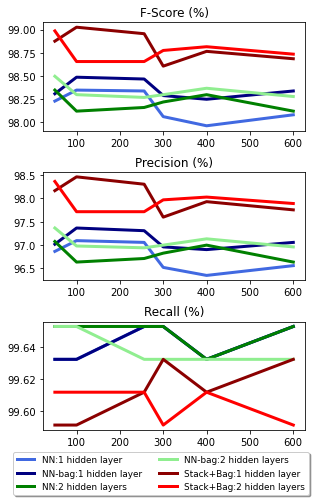

In [15]:
fig, axs = plt.subplots(3, figsize=(4.7, 7.5))
axs[0].set_title('F-Score (%)')
axs[0].plot(x_for_graph, 
            hidden_layer_depth_1_FEBRL_nn_fs_rounded, 
            label = "NN:1 hidden layer",
            color="royalblue", 
            linewidth=3)
axs[0].plot(x_for_graph, 
            hidden_layer_depth_1_FEBRL_nn_bag_fs_rounded, 
            label = "NN-bag:1 hidden layer", 
            color="navy", 
            linewidth=3)
axs[0].plot(x_for_graph, 
            hidden_layer_depth_2_FEBRL_nn_fs_rounded, 
            label = "NN:2 hidden layers", 
            color='green', 
            linewidth=3)
axs[0].plot(x_for_graph, 
            hidden_layer_depth_2_FEBRL_nn_bag_fs_rounded, 
            label = "NN-bag:2 hidden layers", 
            color='lightgreen', 
            linewidth=3)
axs[0].plot(x_for_graph, 
            hidden_layer_depth_1_FEBRL_ensemble_fs_rounded, 
            label = "Stack+Bag:1 hidden layer", 
            color='darkred',
            linewidth=3)
axs[0].plot(x_for_graph, 
            hidden_layer_depth_2_FEBRL_ensemble_fs_rounded, 
            label = "Stack+Bag:2 hidden layers", 
            color='red',
            linewidth=3)

axs[1].set_title('Precision (%)')
axs[1].plot(x_for_graph, 
            hidden_layer_depth_1_FEBRL_nn_pr_rounded, 
            label = "NN:1 hidden layer",
            color="royalblue", 
            linewidth=3)
axs[1].plot(x_for_graph, 
            hidden_layer_depth_1_FEBRL_nn_bag_pr_rounded, 
            label = "NN-bag:1 hidden layer", 
            color="navy", 
            linewidth=3)
axs[1].plot(x_for_graph, 
            hidden_layer_depth_2_FEBRL_nn_pr_rounded, 
            label = "NN:2 hidden layers", 
            color='green', 
            linewidth=3)
axs[1].plot(x_for_graph, 
            hidden_layer_depth_2_FEBRL_nn_bag_pr_rounded, 
            label = "NN-bag:2 hidden layers", 
            color='lightgreen', 
            linewidth=3)
axs[1].plot(x_for_graph, 
            hidden_layer_depth_1_FEBRL_ensemble_pr_rounded, 
            label = "Stack+Bag:1 hidden layer", 
            color='darkred',
            linewidth=3)
axs[1].plot(x_for_graph, 
            hidden_layer_depth_2_FEBRL_ensemble_pr_rounded, 
            label = "Stack+Bag:2 hidden layers", 
            color='red',
            linewidth=3)

axs[2].set_title('Recall (%)')
axs[2].plot(x_for_graph, 
            hidden_layer_depth_1_FEBRL_nn_re_rounded, 
            label = "NN:1 hidden layer",
            color="royalblue", 
            linewidth=3)
axs[2].plot(x_for_graph, 
            hidden_layer_depth_1_FEBRL_nn_bag_re_rounded, 
            label = "NN-bag:1 hidden layer", 
            color="navy", 
            linewidth=3)
axs[2].plot(x_for_graph, 
            hidden_layer_depth_2_FEBRL_nn_re_rounded, 
            label = "NN:2 hidden layers", 
            color='green', 
            linewidth=3)
axs[2].plot(x_for_graph, 
            hidden_layer_depth_2_FEBRL_nn_bag_re_rounded, 
            label = "NN-bag:2 hidden layers", 
            color='lightgreen', 
            linewidth=3)
axs[2].plot(x_for_graph, 
            hidden_layer_depth_1_FEBRL_ensemble_re_rounded, 
            label = "Stack+Bag:1 hidden layer", 
            color='darkred',
            linewidth=3)
axs[2].plot(x_for_graph, 
            hidden_layer_depth_2_FEBRL_ensemble_re_rounded, 
            label = "Stack+Bag:2 hidden layers", 
            color='red',
            linewidth=3)
plt.subplots_adjust(hspace=0.38)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.45, -0.16),
          fancybox=True, shadow=True, ncol=2, prop={"size":8.9})
plt.savefig('sensitivity_to_amount_of_training_data.jpeg')


In [16]:
model_names = ['NN:1 hidden layer', 'NN-bag:1 hidden layer', 'NN:2 hidden layers',
               'NN-bag:2 hidden layers', 'Stack+Bag:1 hidden layer', 'Stack+Bag:2 hidden layers']
fs = []
fs.append(max(hidden_layer_depth_1_FEBRL_nn_fs_rounded) - min(hidden_layer_depth_1_FEBRL_nn_fs_rounded))
fs.append(max(hidden_layer_depth_1_FEBRL_nn_bag_fs_rounded) - min(hidden_layer_depth_1_FEBRL_nn_bag_fs_rounded))
fs.append(max(hidden_layer_depth_2_FEBRL_nn_fs_rounded) - min(hidden_layer_depth_2_FEBRL_nn_fs_rounded))
fs.append(max(hidden_layer_depth_2_FEBRL_nn_bag_fs_rounded) - min(hidden_layer_depth_2_FEBRL_nn_bag_fs_rounded))
fs.append(max(hidden_layer_depth_1_FEBRL_ensemble_fs_rounded) - min(hidden_layer_depth_1_FEBRL_ensemble_fs_rounded))
fs.append(max(hidden_layer_depth_2_FEBRL_ensemble_fs_rounded) - min(hidden_layer_depth_2_FEBRL_ensemble_fs_rounded))

pr = []
pr.append(max(hidden_layer_depth_1_FEBRL_nn_pr_rounded) - min(hidden_layer_depth_1_FEBRL_nn_pr_rounded))
pr.append(max(hidden_layer_depth_1_FEBRL_nn_bag_pr_rounded) - min(hidden_layer_depth_1_FEBRL_nn_bag_pr_rounded))
pr.append(max(hidden_layer_depth_2_FEBRL_nn_pr_rounded) - min(hidden_layer_depth_2_FEBRL_nn_pr_rounded))
pr.append(max(hidden_layer_depth_2_FEBRL_nn_bag_pr_rounded) - min(hidden_layer_depth_2_FEBRL_nn_bag_pr_rounded))
pr.append(max(hidden_layer_depth_1_FEBRL_ensemble_pr_rounded) - min(hidden_layer_depth_1_FEBRL_ensemble_pr_rounded))
pr.append(max(hidden_layer_depth_2_FEBRL_ensemble_pr_rounded) - min(hidden_layer_depth_2_FEBRL_ensemble_pr_rounded))

re = []
re.append(max(hidden_layer_depth_1_FEBRL_nn_re_rounded) - min(hidden_layer_depth_1_FEBRL_nn_re_rounded))
re.append(max(hidden_layer_depth_1_FEBRL_nn_bag_re_rounded) - min(hidden_layer_depth_1_FEBRL_nn_bag_re_rounded))
re.append(max(hidden_layer_depth_2_FEBRL_nn_re_rounded) - min(hidden_layer_depth_2_FEBRL_nn_re_rounded))
re.append(max(hidden_layer_depth_2_FEBRL_nn_bag_re_rounded) - min(hidden_layer_depth_2_FEBRL_nn_bag_re_rounded))
re.append(max(hidden_layer_depth_1_FEBRL_ensemble_re_rounded) - min(hidden_layer_depth_1_FEBRL_ensemble_re_rounded))
re.append(max(hidden_layer_depth_2_FEBRL_ensemble_re_rounded) - min(hidden_layer_depth_2_FEBRL_ensemble_re_rounded))


In [17]:
range_df = pd.DataFrame(model_names, columns=['Models'])

In [18]:
range_df['pr_max_percent_change'] = pr
range_df['re_max_percent_change'] = re
range_df['fs_max_percent_change'] = fs

In [19]:
range_df

,Models,pr_max_percent_change,re_max_percent_change,fs_max_percent_change
0,NN:1 hidden layer,0.748196,0.020433,0.385284
1,NN-bag:1 hidden layer,0.464376,0.020433,0.238126
2,NN:2 hidden layers,0.442382,0.020433,0.227539
3,NN-bag:2 hidden layers,0.426374,0.020433,0.228578
4,Stack+Bag:1 hidden layer,0.866568,0.040866,0.420136
5,Stack+Bag:2 hidden layers,0.650644,0.020433,0.330517
